# 📊 캐글 경진대회 - 무작정 따라하기

- 처음 시작을 어떻게 해야할지 감이 오지않아 아래 커널을 기반으로 진행하였습니다.

https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12?scriptVersionId=12697460

# 1. 데이터 탐색

## 1-1. 문제 정의

- 집과 관련된 정보 데이터를 활용하여 어떤 카테고리에 속하는지를 알아내는게 아니라 실수값을 맞추는 `"집값"`을 예측하는 문제이다.
- 점수 평가 기준은 아래와 같다.
    - RMSE(평균 제곱근 오차)



- ### 시각화 그래프 출력 라이브러리 import

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

- ### 전체 코드 실행에 필요한 packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from scipy import stats # Analysis 
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('O.K 💢')

O.K 💢


- ### 데이터 준비하기  


In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 
# print(train_data_path)
# print(test_data_path)

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)
print(f'train data dim : {df_train.shape}')
print(f'test data dim : {df_test.shape}')
print('O.K 👌')

train data dim : (15035, 21)
test data dim : (6468, 20)
O.K 👌


- 학습 데이터 : 약 15000 여개, 테스트 데이터 : 약 6500 여개
- 전체 대비 비율 - 학습데이터 : 약 70%, 테스트 데이터 : 약 30%
    - 데이터 비율은 나쁘지 않다.
    - 변수 갯수는 아직은 적절한지 아닌지 판단할 수가 없다.  


In [4]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
df_test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


- 테스트 데이터는 `price` 가격이 없기에 컬럼 하나가 적다.<br><br>

## 1-2. 데이터 살펴보기
- 변수 설명은 LMS 노드 참고

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [7]:
# 데이터의 null, type, unique한 값의 수, describe 치환
# 컬럼에 위 3가지 추가 반영 
default_check = pd.concat([df_train.isnull().sum(), df_train.dtypes, df_train.nunique(), df_train.describe().T], axis=1)
default_check.rename(columns={0:'NULL', 1:'TYPE', 2:'UNIQUE'}, inplace=True)
default_check

,NULL,TYPE,UNIQUE,count,mean,std,min,25%,50%,75%,max
id,0,int64,15035,15035.0,7517.000000,4340.374984,0.0000,3758.5000,7517.0000,11275.5000,1.503400e+04
date,0,object,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,0,float64,3263,15035.0,540682.653143,371524.660390,78000.0000,322000.0000,450000.0000,645000.0000,7.700000e+06
bedrooms,0,int64,11,15035.0,3.369139,0.902721,0.0000,3.0000,3.0000,4.0000,1.000000e+01
bathrooms,0,float64,29,15035.0,2.115065,0.767519,0.0000,1.7500,2.2500,2.5000,8.000000e+00
sqft_living,0,int64,863,15035.0,2083.790223,922.134087,290.0000,1430.0000,1910.0000,2560.0000,1.354000e+04
sqft_lot,0,int64,7678,15035.0,15296.965813,42612.821375,520.0000,5027.5000,7620.0000,10695.5000,1.651359e+06
floors,0,float64,6,15035.0,1.498071,0.538522,1.0000,1.0000,1.5000,2.0000,3.500000e+00
waterfront,0,int64,2,15035.0,0.007117,0.084063,0.0000,0.0000,0.0000,0.0000,1.000000e+00
view,0,int64,5,15035.0,0.234253,0.763376,0.0000,0.0000,0.0000,0.0000,4.000000e+00


- 변수 price 값의 분포를 확인 
- 값이 정규분포에 비해 얼마나 치우쳐져 있는지, 분포에 존재하는 특이치(outlier) 가 있는지 등을 확인해 보자<br>

In [8]:
# skewness(왜도) and kurtosis(첨도)
print("Skewness(왜도): %f" % df_train['price'].skew())
print("Kurtosis(첨도): %f" % df_train['price'].kurt())

Skewness(왜도): 4.290252
Kurtosis(첨도): 40.154919


- 왜도가 4 이상으로 왼쪽에 데이터가 많은 상태
- 첨도가 40 이상으로 특이치들이 많은 것으로 확인
- Positive skewed 데이터를 변환하는 방법 중 log 적용하여 변환

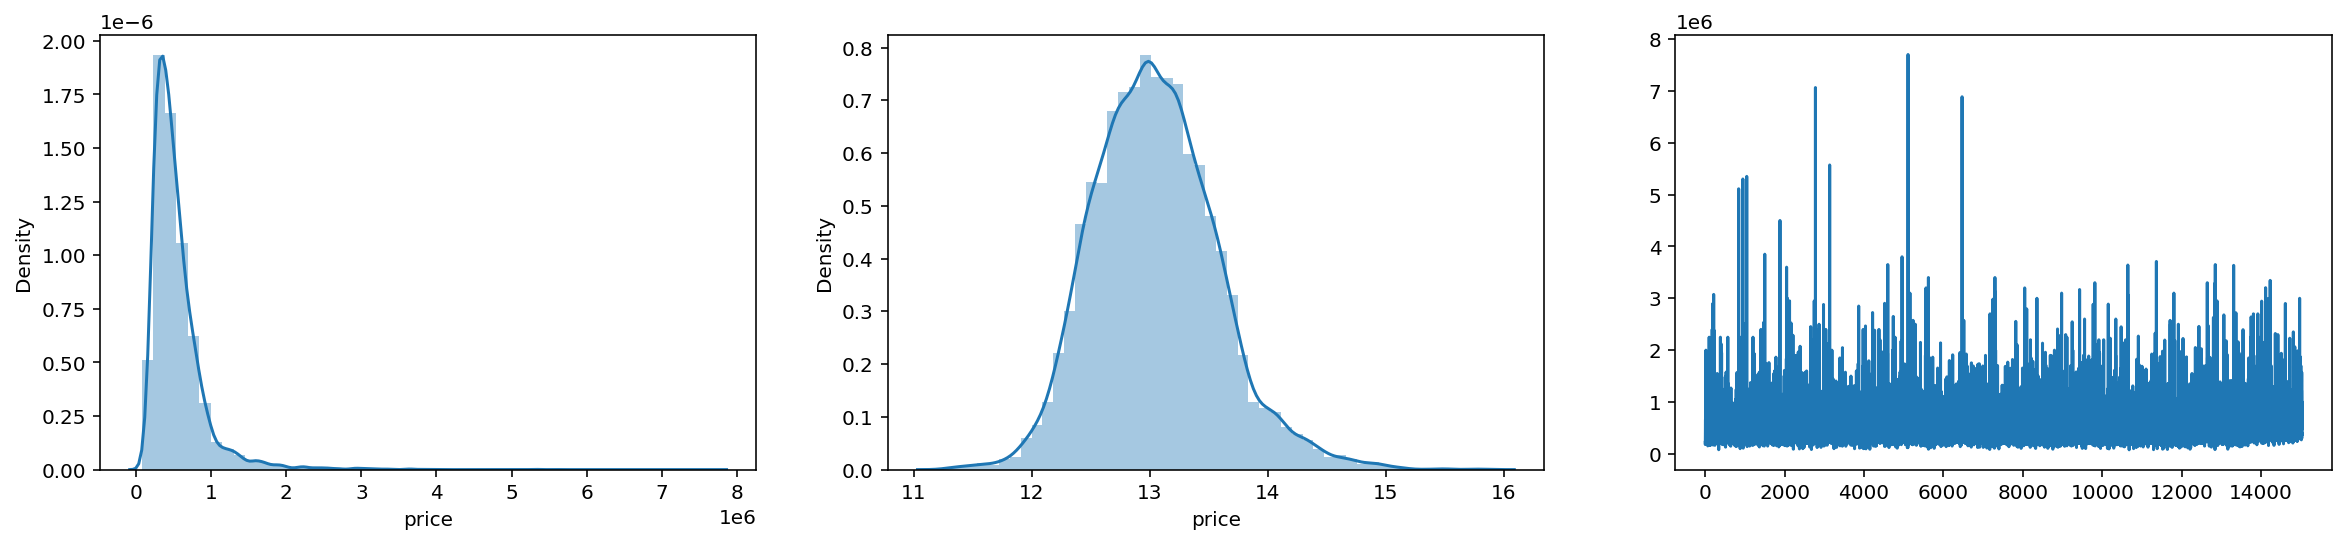

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(df_train['price'], ax=ax[0]) 
sns.distplot(np.log1p(df_train['price']), ax=ax[1])
df_train['price'].plot(ax=ax[2])
plt.show()

- 위 첫번째 그래프와 같이 좌측으로 많이 치우친 것을 확인
- log 적용하여 두번째 그래프와 같이 정규분포 형태로 잘 변환됨


### 참고  
- Skewness(왜도) : 데이터 분포가 한쪽으로 쏠린 것을 의미
    - `positive Skewness` : 오른쪽에 꼬리를 가진(왼쪽에 데이터가 많은) 형태
    - `Negative Skewness` : 왼쪽에 꼬리를 가진(오른쪽에 데이터가 많은) 형태
    - 일반적으로 고려 가능한 Un-Skew 수치는 +2 ~ -2 사이
    - Skewness를 측정한 값 기준 :  -2 ~ +2는 치우침이 없는 데이터
    - `-2 미만 : Negative Skew, +2 초과 : Positive Skew`

- Skewed 데이터를 변환하는 이유 : `꼬리에 있는 값을 모델에 제대로 학습시키기 위함` 
    - Skewed 되어있는 값을 그대로 학습시키면 꼬리 부분이 상대적으로 적고 멀어서 모델에 영향이 거의 없이 학습.
    - 만약 꼬리 부분도 노이즈가 아닌 정말 유의미한 데이터이면 꼬리 부분에 해당하는 test 데이터는 예측력이 낮아짐.
    - 변환을 해서 들어가게 되면 그만큼 데이터의 중간값(or 평균값)가 tail 하고 가까워져서 모델에 보다 크게 들어간다. 그렇게 되면 꼬리 쪽에 해당하는 test 데이터가 들어와도 예측력이 높아짐.

- Skew 데이터를 변환하는 방법 : square root, cube root, log, outlier 제거 등
    - `Positive skewed(right skewed)` 변환방법 : square root, cube, `log`
    - Negative skewed(left skewed) 변환방법 : square, cube root, logarithmic
      
출처: https://rucrazia.tistory.com/65 [Rucrazia's Blog]


#### [예시]

- 흔한 집값을 예로 들면. 1억 원 ~ 10억 원 사이의 주택들의 데이터가 있다고 가정하자.
- 분포의 피크가 평균값에서 왼쪽에 있을 경우 분포의 Positive Skewness이다. 그 말은 즉슨 많은 집들이 평균값, 즉 5억 원(정확히는 5.5억) 이하의 가격에 팔리고 있다는 것을 의미한다.
- 분포 피크가 평균값과 보다 오른쪽에 있다면 이는 Negative Skewness을 의미한다. 집들이 평균값보다 더 높은 가격으로 많이 팔리고 있다는 것을 의미한다.

출처: https://dining-developer.tistory.com/17 [밥먹는 개발자]  
<br>

- 두 변수간의 분포를 비교하기 위해 scipy.stats 를 이용한 QQ plot 그리기

출처: https://blog.naver.com/breezehome50/222339337268

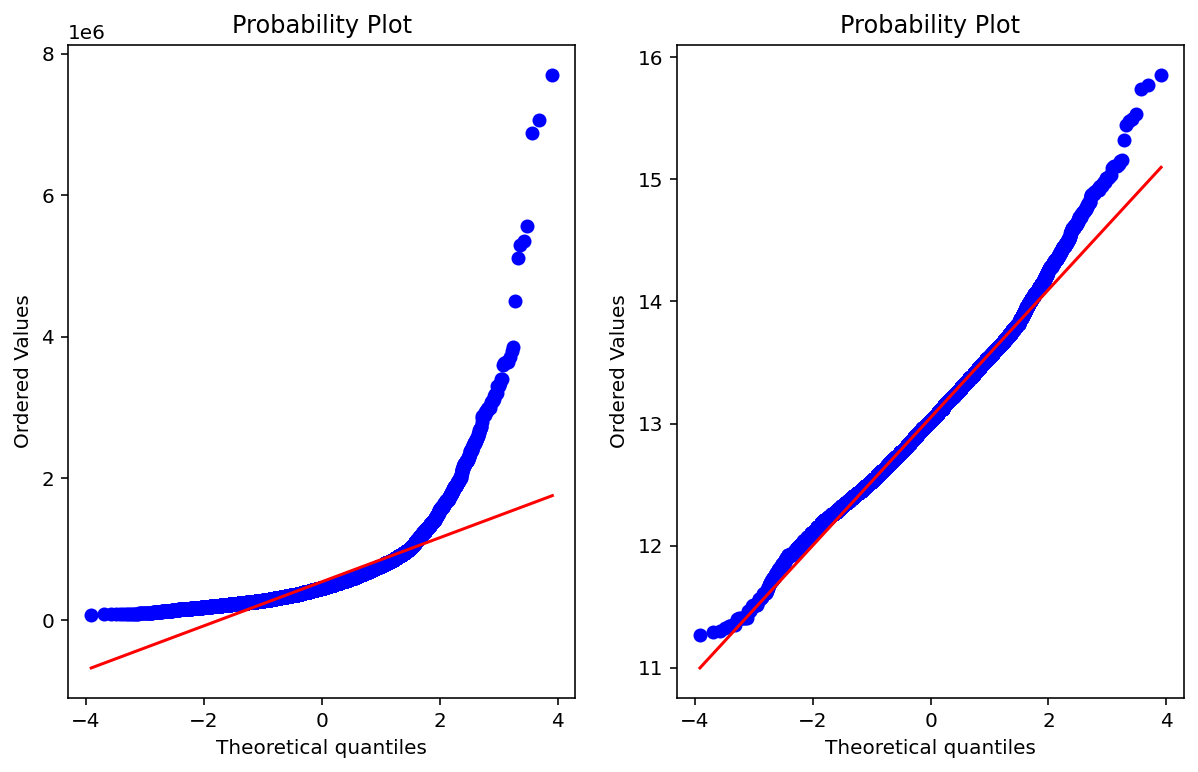

In [10]:
fig = plt.figure(figsize = (10,6))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

- log 를 취해주면 우측 그래프와 같이 기존보다 더 정규성을 갖게 되는 것을 확인 할 수 있다.
- df 원본에 반영하자.

<AxesSubplot:xlabel='price', ylabel='Density'>

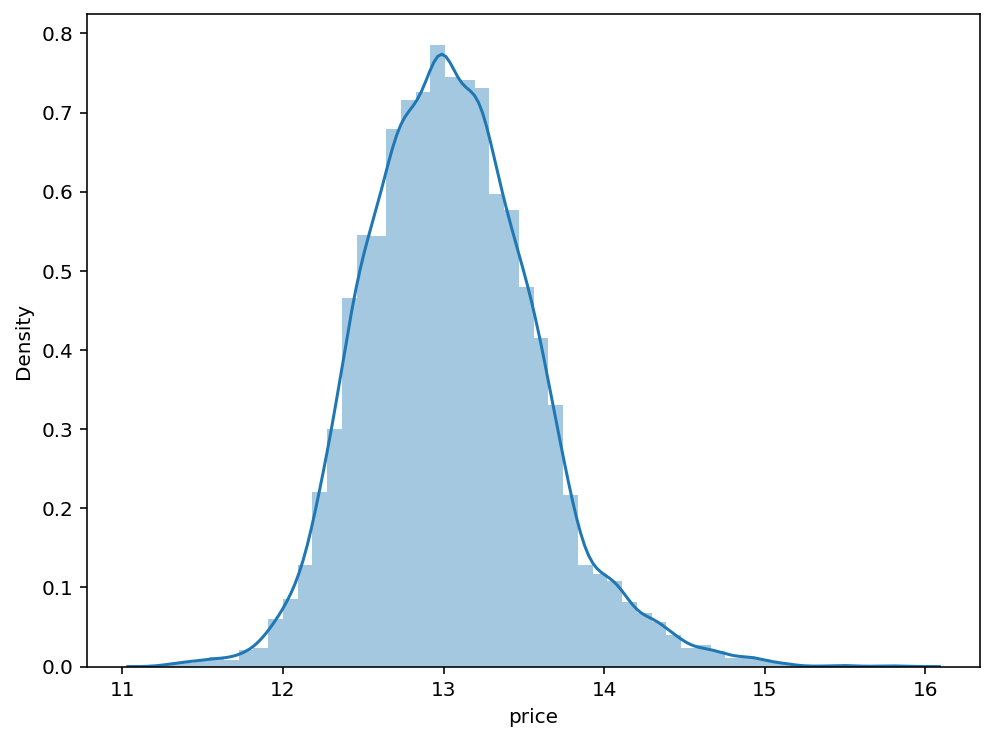

In [11]:
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

## 1-3. 변수 시각화
- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우 사용

- 스피어만 상관계수가 높은 순서대로 본 히트맵입니다. 상관도가 높은 상위 8개의 값만 보았습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms']


<AxesSubplot:title={'center':'Spearman correlation of heatmap'}>

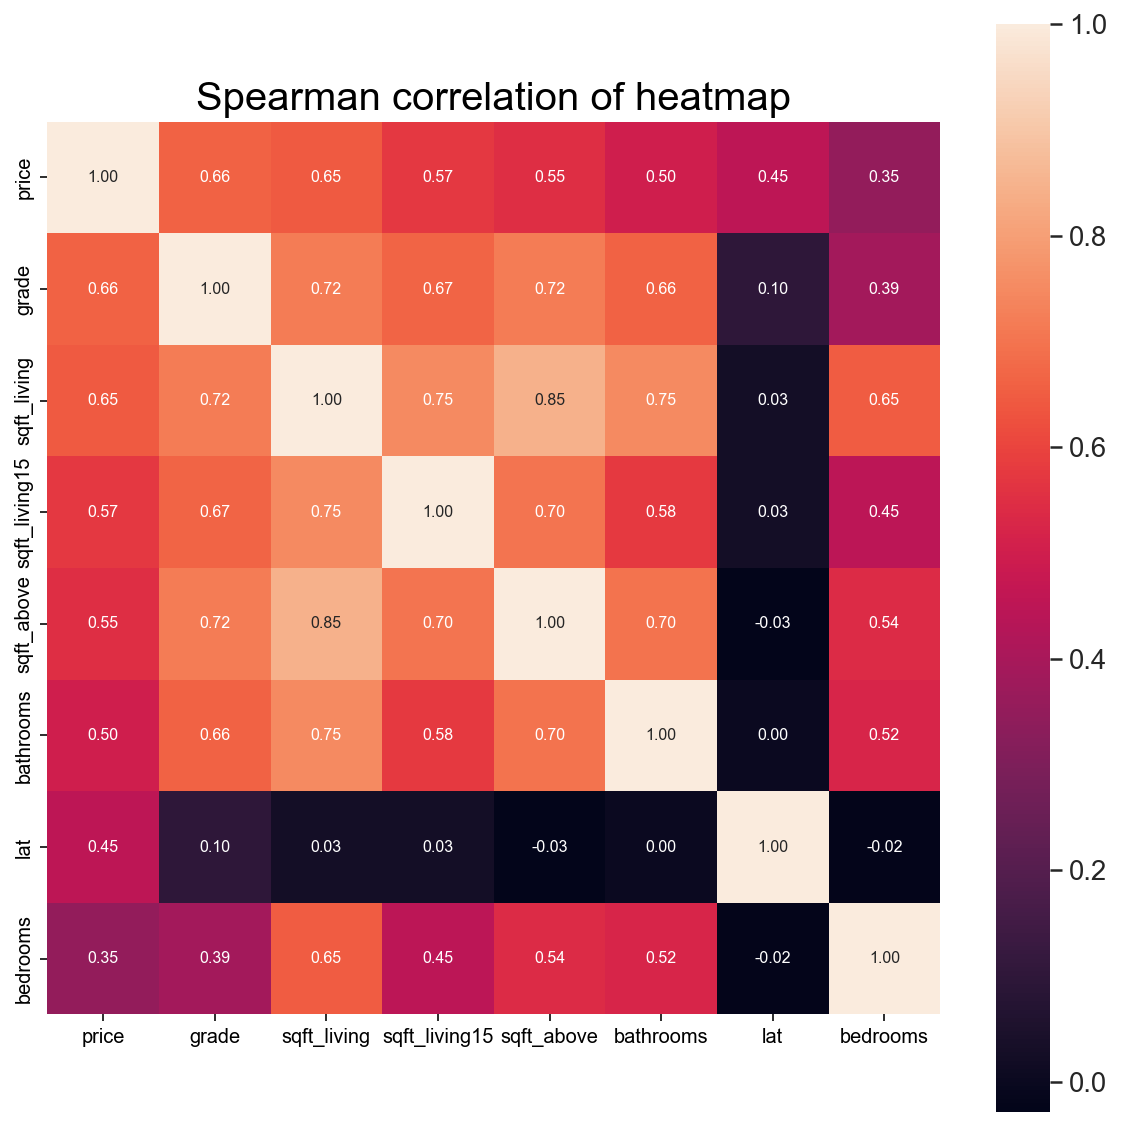

In [12]:
# correlation이 높은 상위 8개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12/ 코드 참고. 
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=8, columns='price').index # price과 correlation이 높은 column 8개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 8 x 8
print(cor_cols.values)
plt.figure(figsize=(10,10))
plt.title('Spearman correlation of heatmap', fontsize=20)
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

- 목적변수와 상관도가 높은 변수
- `grade > sqft_living > sqft_living15 > sqft_above > bathrooms> lat> bedrooms` 순
- 연관성이 없어보이지만 `lat`이라는 위도 값이 포함 
- 위도가 변함에 따라 가격이 어떻게 변화하는지? 에 대한 궁금증 해결에는 좀 더 탐색이 필요해보인다.
___

- 위의 `lat`의 경우 `price`와 상관성이 있는 것을 [여기](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83549)에서 참고하면, 위 지역 시애틀의 경우 북쪽지역이 잘 정리되고 살기 좋은 집들이 많은 것으로 나온다고 합니다.


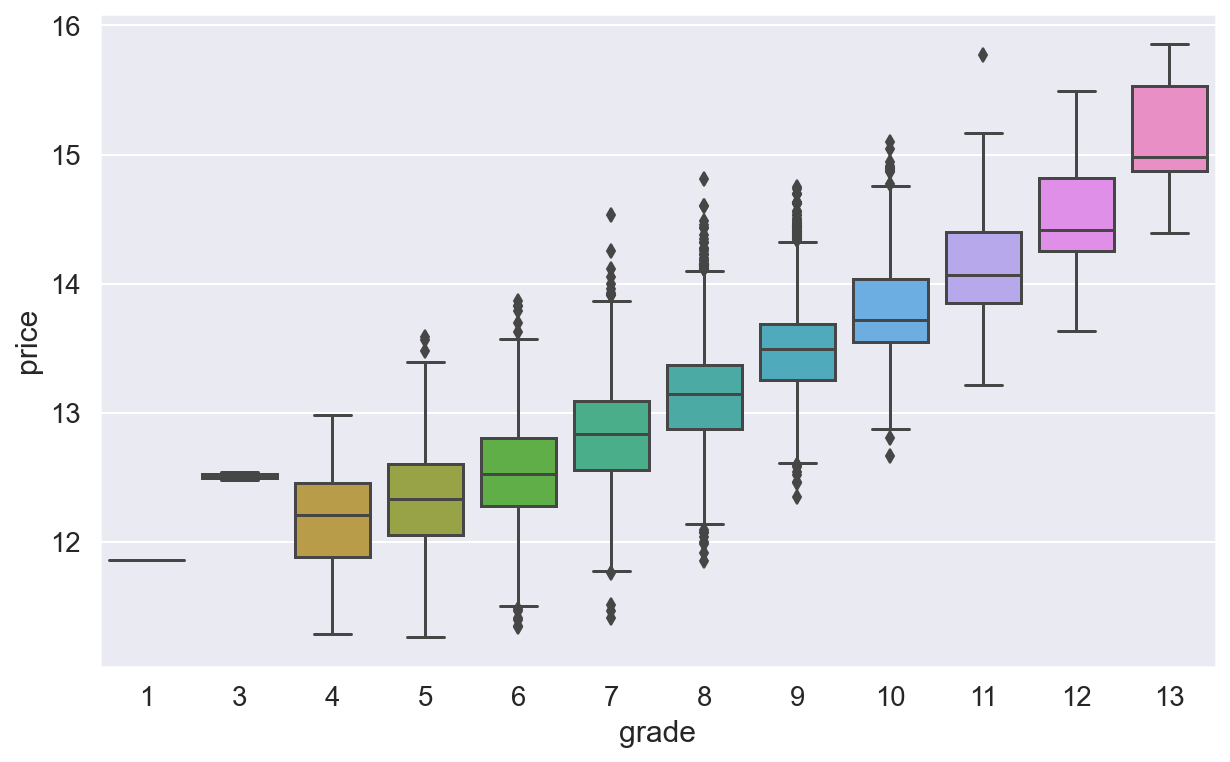

In [13]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='grade', y="price", data=df_train)

- grade의 경우 "*1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다.*" 라고 합니다. 

- 집의 등급이 높으면 가격이 좋아지는 것은 위의 히트맵에서도 봤듯이 당연합니다. 그리고 전박적으로 상승곡선의 형태도 보이고 있습니다. 하지만 
    - ***등급 3의 경우 값이 큰 이유***
    - ***등급 7, 8과 11에서 차이가 큰 이상치가 나타나는 이유***

- 위의 2가지는 좀 더 자세히 살펴봐야 합니다. 

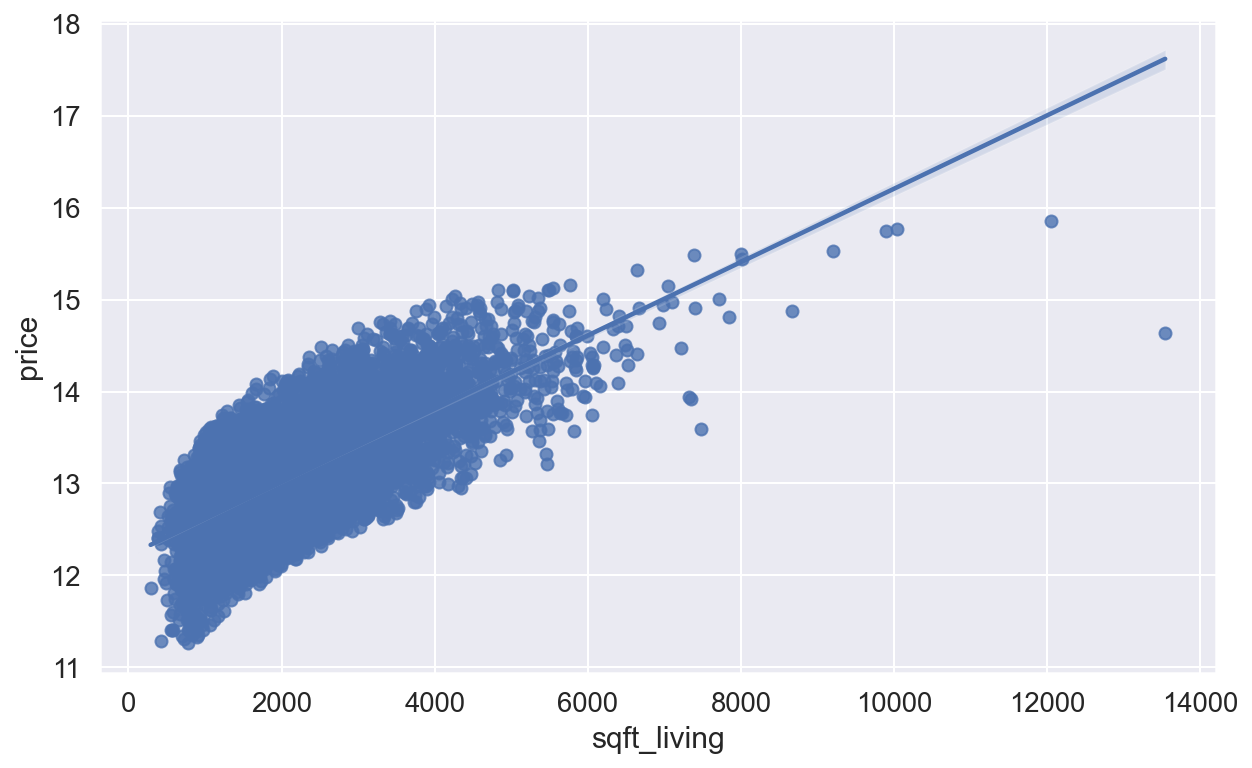

In [14]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.regplot(x='sqft_living', y="price", data=df_train)

### sqlf_living / sqlf_lot  
(주거 평방 피트 / 부지 평방 피트)

- 1sqlf는 0.0281평입니다. sqlf_lot는 부지 평방 피트인데, 흔히 우리나라의 경우, 32평형 아파트는 일반적으로 실제로 쓰는 전용 면적은 25.7평 정도입니다. 

    `즉, sqlf_living은 실제 사용 면적 / sqlf_lot는 총 부지의 면적으로 생각하면 됩니다.`  


- 전반적으로 선형성을 보이지만 가격이 14~15사이에 sqft_living이 14000에 가까운 값은 꽤나 이상한 값(이상치)으로 생각되어집니다. 제거할지 말지는 저 값을 확인해보고 결정하겠습니다

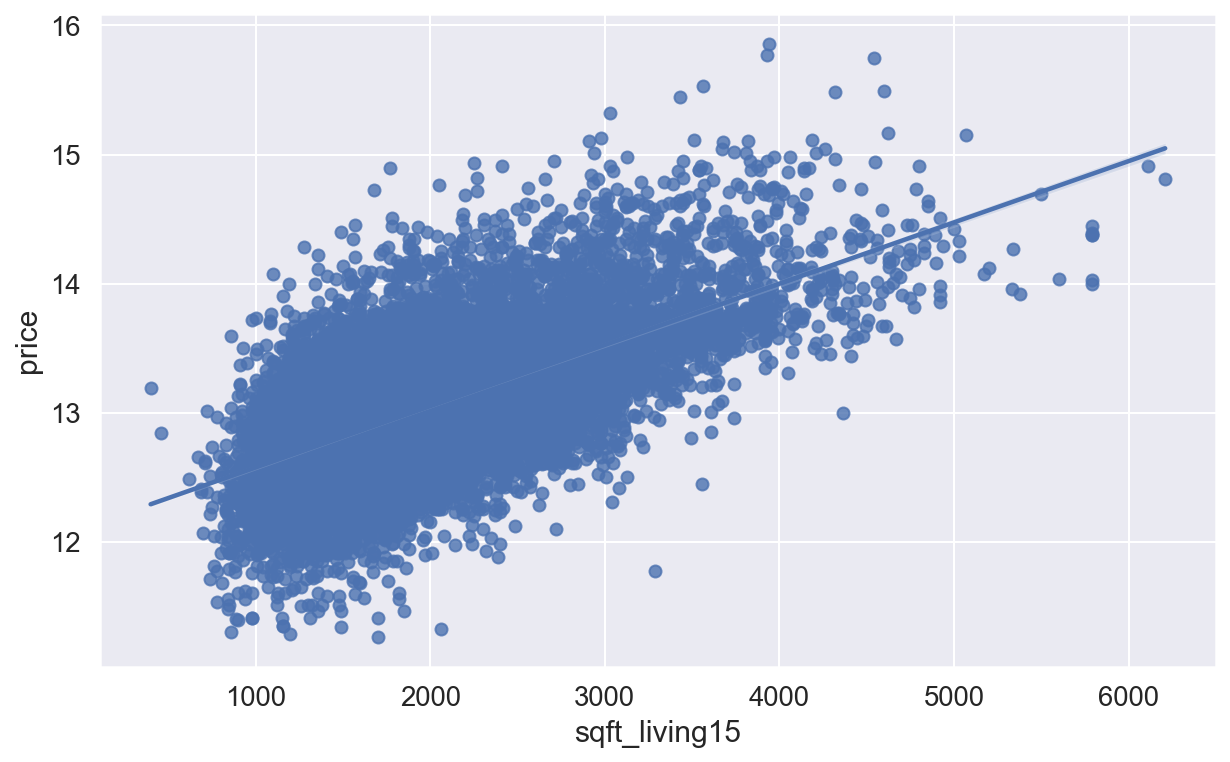

In [15]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=df_train)

- sqft_living15의 경우 15년도를 기준으로 했다보니 sqft_living에 비해 가격의 분산이 큽니다.
- 아무래도 재건축으로 인한 영향일 것으로 생각되어지고 sqft_living15 그 자체를 사용하기보다는 적절한 Feature Engineering이 필요해 보입니다. 

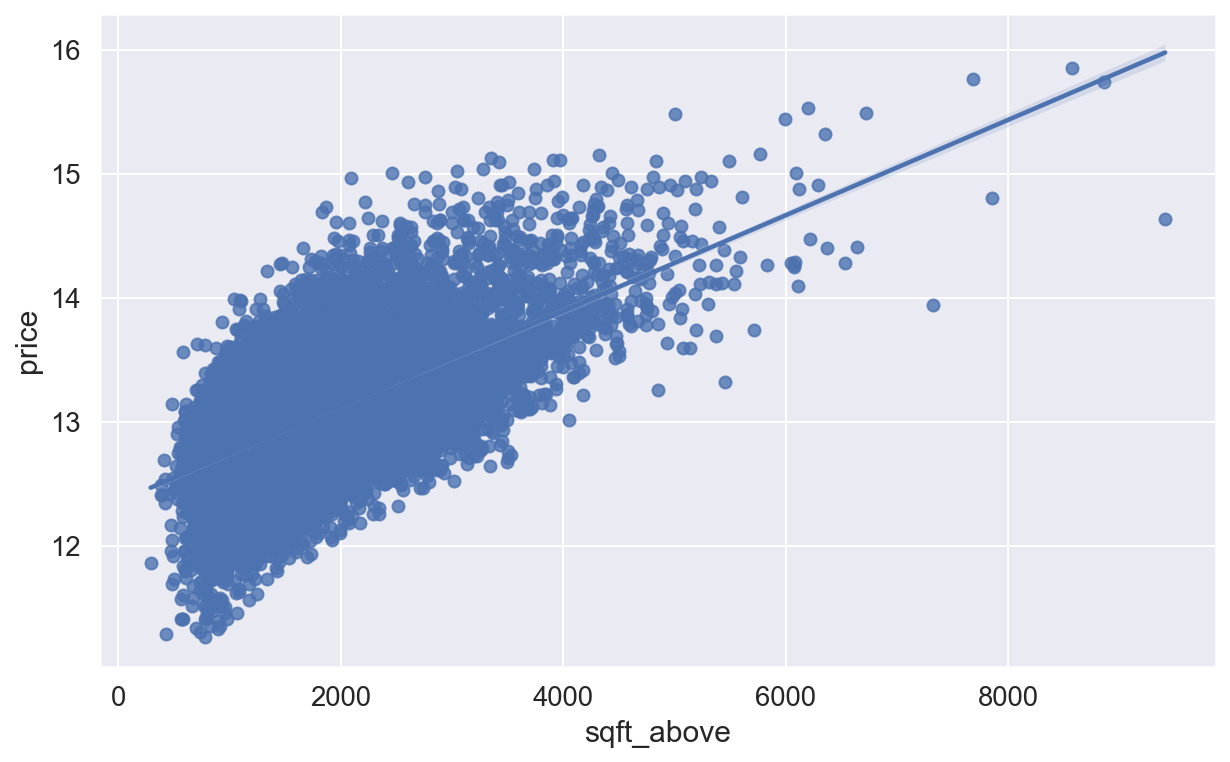

In [16]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.regplot(x='sqft_above', y="price", data=df_train)

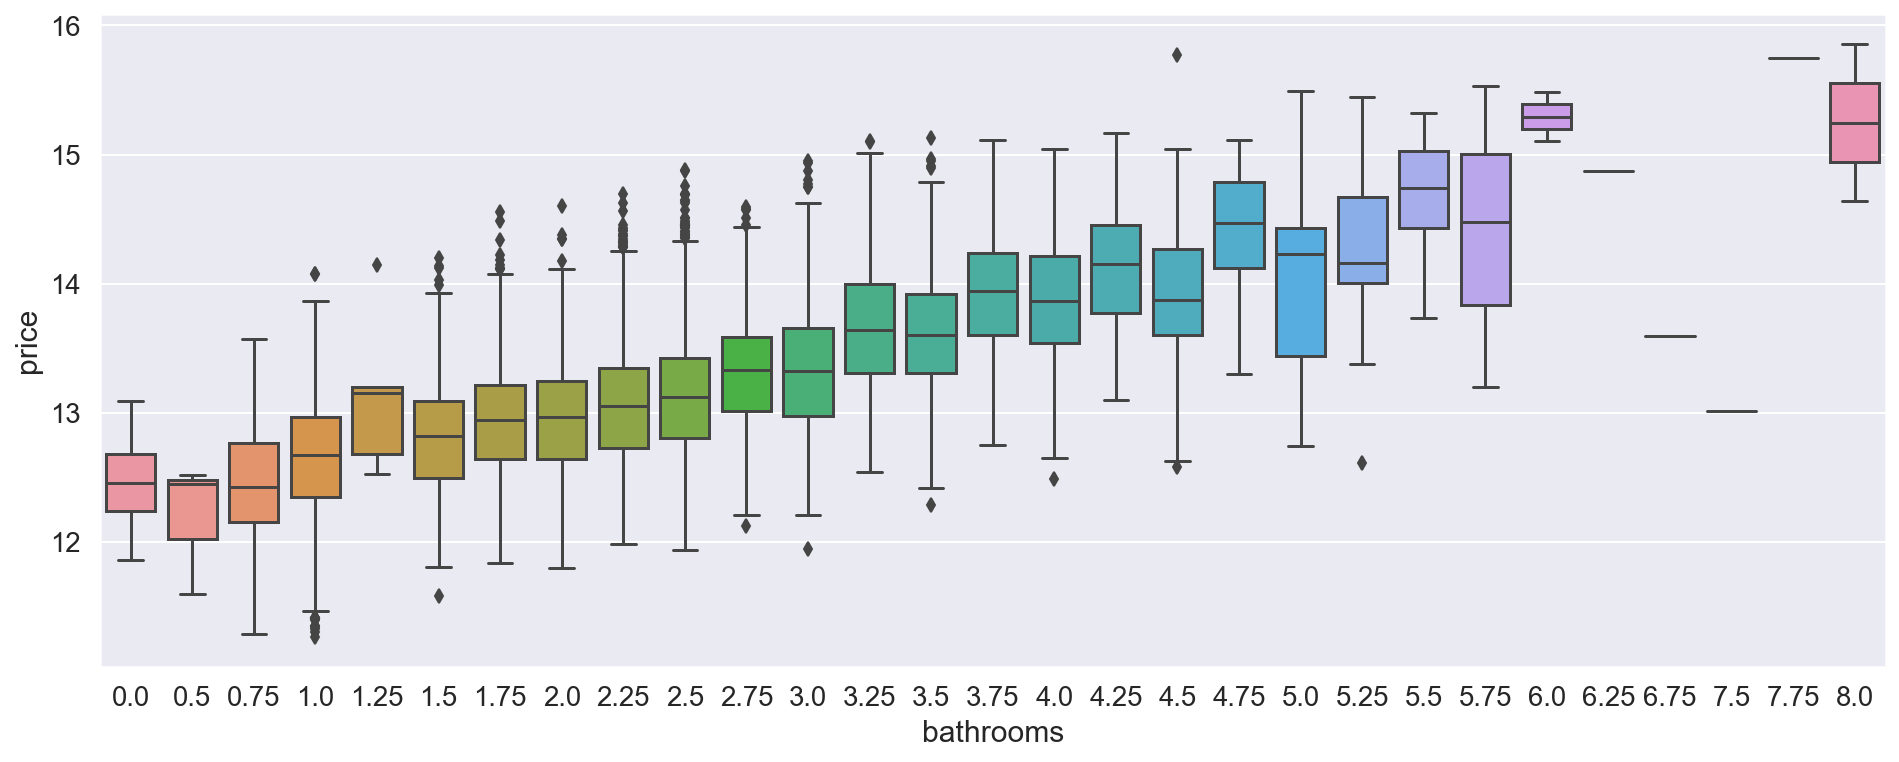

In [17]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(16, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=df_train)

- bathrooms같은경우 소숫점이 있어서 많이 헷갈릴 수 있습니다. 각각의 값이 의미하는것은 아래와 같고 위의 값만을 가지고 각각의 값이 몇개있는지는 구분하기 힘들어 보입니다. 
    - 0.5 : 세면대, 화장실 
    - 0.75 : 세면대, 화장실, 샤워실
    - 1 : 세면대, 화장실, 샤워실, 욕조 

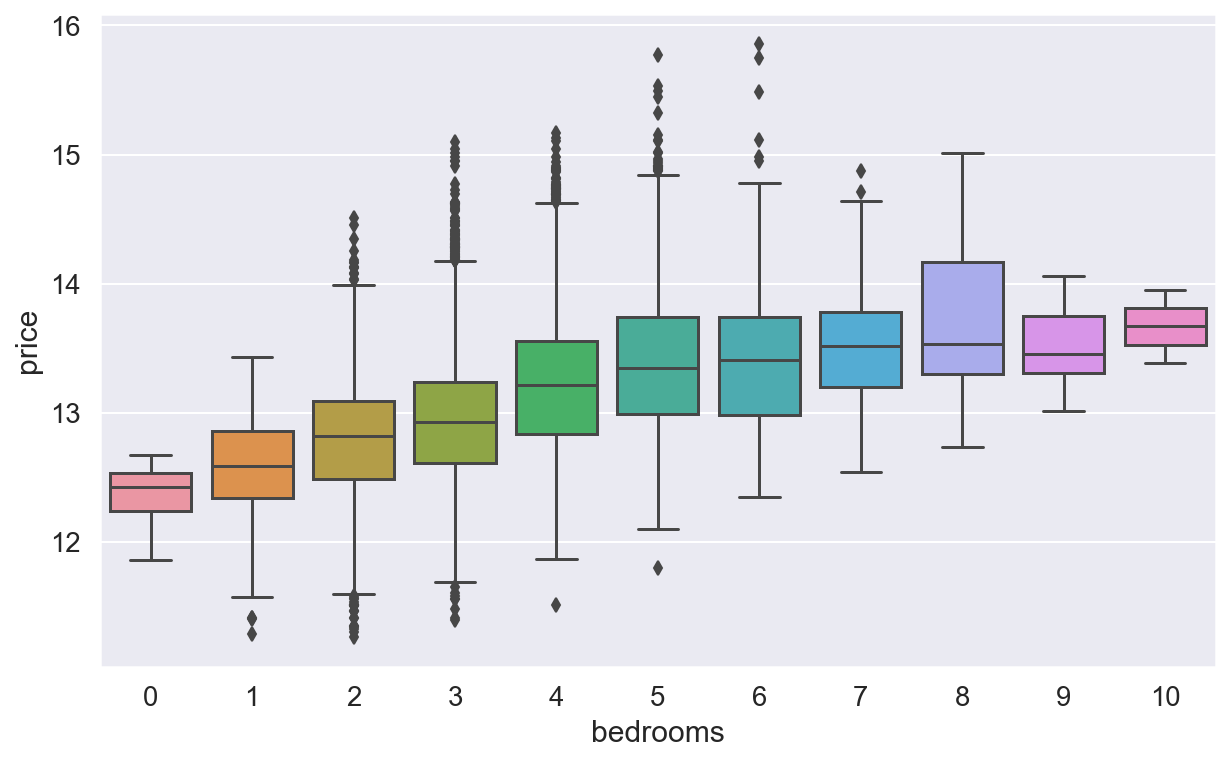

In [18]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=df_train)

- 방의 경우 median 값을 중심으로 살펴보면 어느정도 선형관계를 띄는것을 볼 수 있습니다. 그리고 방의 갯수가 2~6의 경우 방이 적음에도 값이 큰 값들이 많습니다.
- 이는 우리나라의 경우처럼 방의 크기는 작아도 강남처럼 비싼 지역일 가능성이 높습니다.  

## 1-4. 결측치


In [19]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import plotly.graph_objs as go

import time
import random

#https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-nn-approach
def mis_value_graph(data):  
    data = [
    go.Bar(
        x = data.columns,
        y = data.isnull().sum(),
        name = 'Counts of Missing value',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
    layout= go.Layout(
        title= '"Total Missing Value By Column"',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='skin')
    
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color

df_all = pd.concat([df_train,df_test])
del df_all['price']
mis_value_graph(df_all)

- 위 그래프와 같이 결측치는 없는 상황입니다.

## 1-5. 유니크한 개수

In [20]:
### 유니크 갯수 계산
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(df_train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
layout= go.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')

- view의 유니크갯수가 5인걸로 보니 grade같이 순위형 변수로 생각되어지고 waterfront의 경우는 2개로 `있다/없다`를 상징하는 것 같습니다. 위에서 몇몇 값들을 자세히 살펴보면,

In [21]:
df_train['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

- 층수의 경우 1.5, 2.5, 3.5와 같이 소숫점을 가집니다. 이는 미국에서 흔히 볼 수 있는 형태로 다락방을 끼고 있는 형태로 생각하시면 됩니다.

# 2. 데이터 전처리

## 2-1. 이상치 제거

위에서 중요한 변수들에 대해 시각화를 해봤을때, 다음의 변수들에 대해 이상치가 있는 것을 확인할 수 있었습니다.

- sqft_living, grade, bedrooms

### 2-1-1. sqft_living

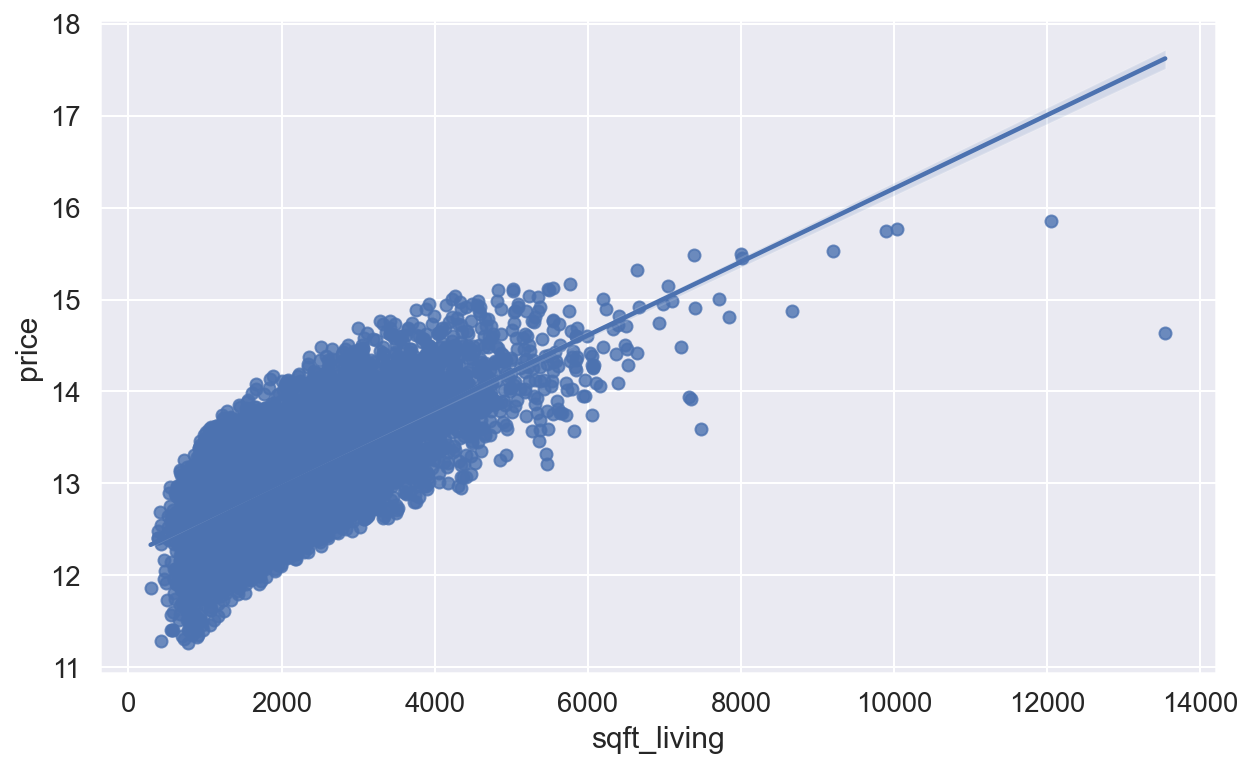

In [22]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [23]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


- 위의 그래프와 값도 확인해보니, 단 1건 밖에 없는 이상치로 봐도 무방하다고 판단하여 제거하도록 하겠습니다.

In [24]:
df_train = df_train.loc[df_train['id'] != 8912]

### 2-1-2. grade

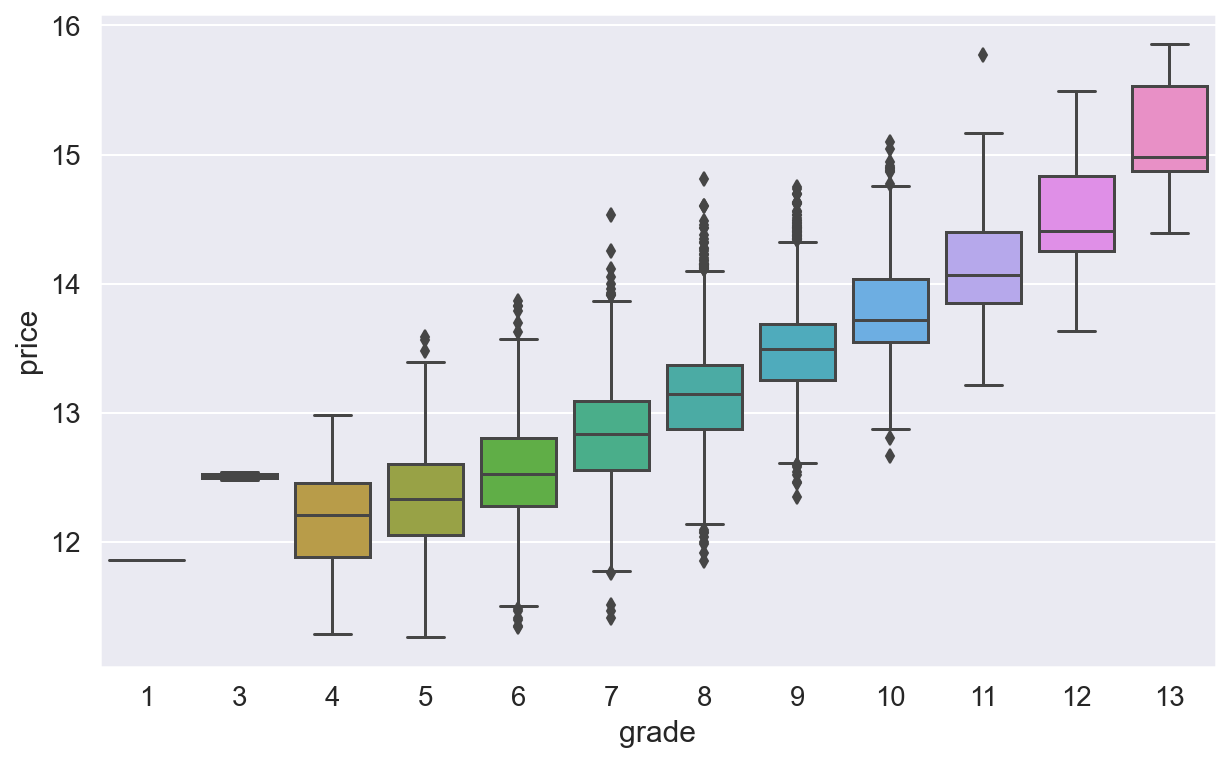

In [25]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

- 위 1-3. 변수 시각화에서 좀더 살펴보기로 했던 아래 내용들
    - ***등급 3의 경우 값이 큰 이유***
    - ***등급 7, 8과 11에서 차이가 큰 이상치가 나타나는 이유***

In [26]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


- 가장 중요한 변수인 grade, sqft_living 모두 낮은 것을 볼 수 있습니다. 
- 두 값 모두 이상치로 규정하고 제거하도록 하겠습니다.

In [27]:
df_train.loc[(df_train['price']>14.5) & (df_train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,4,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [28]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [29]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


- 위의 세가지 조건의 값들은 이상치로 봐도 무방하다고 판단하여 제거하도록 하겠습니다.

### 2-1-3. bedrooms

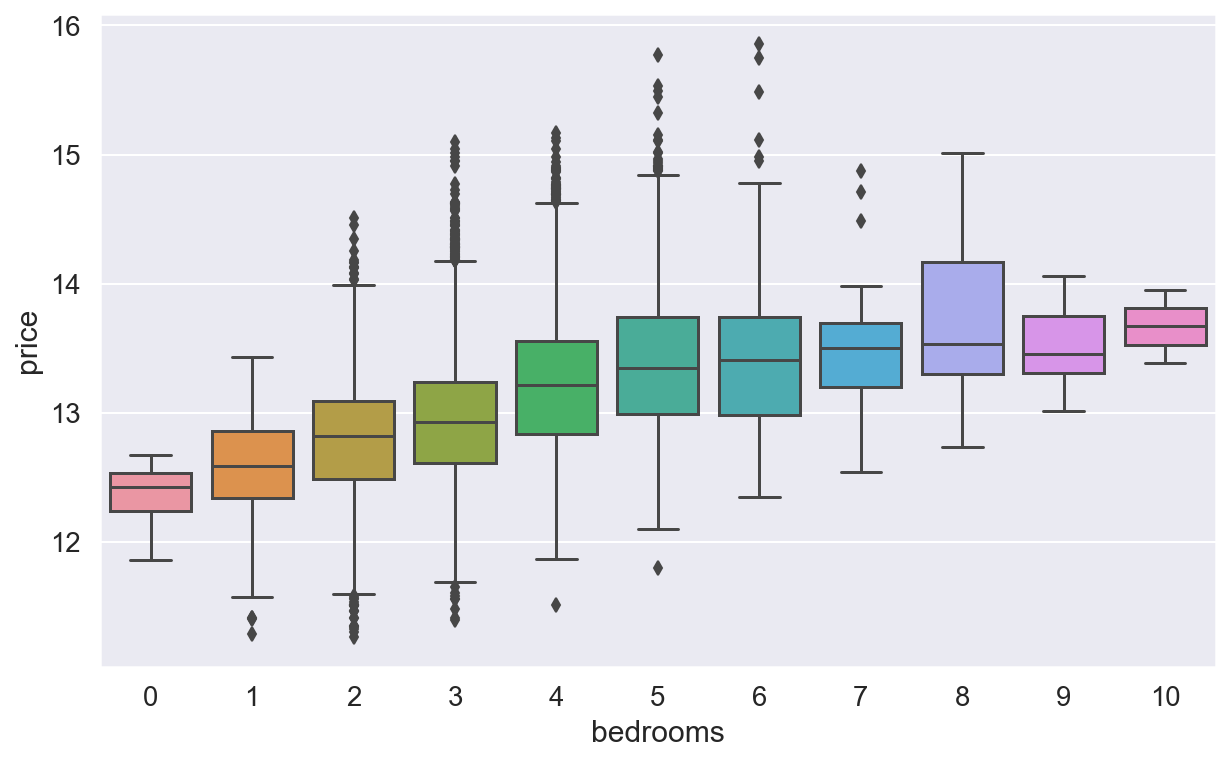

In [30]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

- 침실의 수를 보면 median이 양의 상관관계를 띄고 있고 bedrooms가 2 ~ 6은 분산이 매우 큰 것을 확인할 수 있습니다.
- 가운데의 저 값들은 다른 변수들의 영향이 크므로 위의 정보만을 보고 제거하지는 않도록 하겠습니다.

## 2-2. 정규화



In [31]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

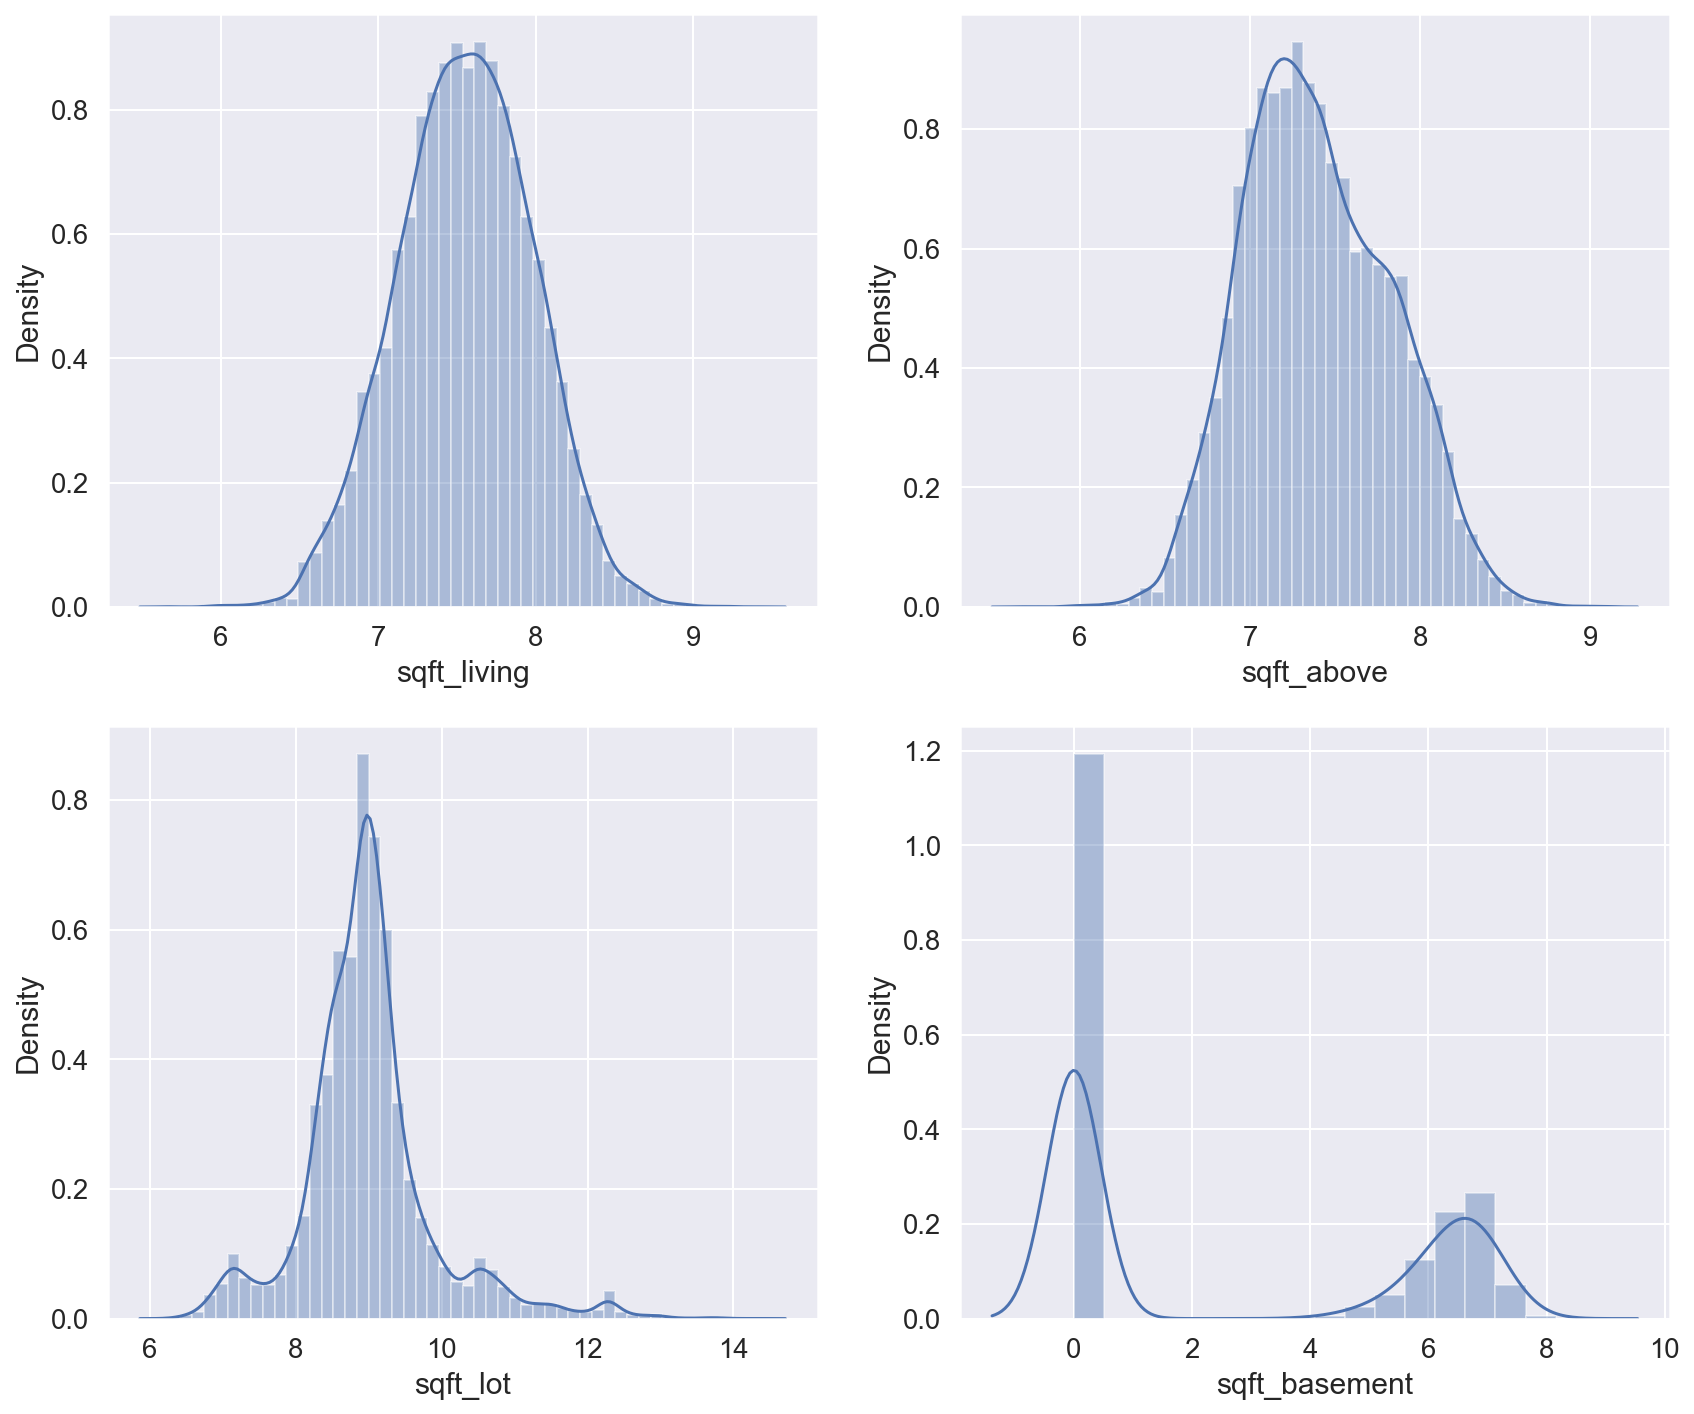

In [32]:
#histogram
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
sns.distplot(df_train['sqft_living'], ax=ax[0][0])
sns.distplot(df_train['sqft_lot'], ax=ax[1][0])
sns.distplot(df_train['sqft_above'], ax=ax[0][1])
sns.distplot(df_train['sqft_basement'], ax=ax[1][1])
plt.show()

## 2-3. 변수 수정

In [33]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [34]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991.0,98125,47.7210,-122.319,1690,7639
1,15036,20141209,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,1965.0,98136,47.5208,-122.393,1360,5000
2,15037,20140512,4,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,2001.0,98053,47.6561,-122.005,4760,101930
3,15038,20150415,3,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,1960.0,98146,47.5123,-122.337,1780,8113
4,15039,20150312,3,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,2003.0,98038,47.3684,-122.031,2390,7570


# 3. 변수 생성

In [35]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [36]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [37]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated
0,15035,20141209,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991.0,98125,47.7210,-122.319,1690,7639,5.25,0.883465,13.676905,0.574110,0.221233,1
1,15036,20141209,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,1965.0,98136,47.5208,-122.393,1360,5000,7.00,0.890086,13.772040,0.550478,0.272000,0
2,15037,20140512,4,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,2001.0,98053,47.6561,-122.005,4760,101930,8.50,0.745577,15.600098,0.551153,0.046699,0
3,15038,20150415,3,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,1960.0,98146,47.5123,-122.337,1780,8113,4.00,0.839232,13.551911,0.552315,0.219401,0
4,15039,20150312,3,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,2003.0,98038,47.3684,-122.031,2390,7570,5.50,0.858454,7.544861,1.000000,0.315720,0


- 아래는 집값 같은 경우는 비슷한 지역에 영향을 받아서 그것을 코드로 구현한 것 입니다. 주의해야 할 점은 단순 집값이 아니라 평당 가격을 써야 한다는 점 입니다 !!!

In [38]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

# 4. 모델링

## 4-1. 단순 선형회귀

In [39]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,4.00,0.818803,7.074117,1.0,0.237168,0,1.740145,9.368147,1.214207
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00,0.721756,6.647688,1.0,0.337385,0,1.820290,9.257745,1.023549
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,5.00,0.825489,7.427144,1.0,0.239904,0,1.769478,11.307711,0.826257
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819,5.25,0.843688,7.447751,1.0,0.328201,0,1.672824,10.626177,1.012780
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711,4.50,0.758837,6.966967,1.0,0.169910,0,1.806238,10.032009,1.002206


In [40]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in df_train.columns if c not in ['id','price','per_price']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.743e+06
Date:                Mon, 24 Jan 2022   Prob (F-statistic):                        0.00
Time:                        19:55:56   Log-Likelihood:                         -23.307
No. Observations:               15034   AIC:                                      96.61
Df Residuals:                   15009   BIC:                                      287.1
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

- 모델의 설명력을 보면 1로 굉장히 높지만, 각각의 변수들 중에서는 `p-value`가 높은 값들이 있음을 확인할 수 있습니다.
- 그러한 이유를 생각해보면 Feature Engineering해서 나온 파생변수들은 기존의 변수와 연관되어있고
- `sqft_`로 시작하는 변수들끼리의 상관성 등이 있어서 다중공선성의 문제를 가지기 때문입니다.
- 실제로 다중공선성을 체크하기 위해 `vif`를 이용한 확인을 하면

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF Values"] = [variance_inflation_factor(
    df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
23,sqft_total_size,inf
21,total_rooms,inf
3,bedrooms,inf
4,bathrooms,inf
13,sqft_basement,inf
12,sqft_above,inf
16,zipcode,5.292510e+06
1,date,4.282491e+06
18,long,2.051766e+06
17,lat,2.435344e+05


- 보통의 경우 10 이상이면 다중공선성이 존재한다고 말하는데, 위의 식에서는 waterfront, view, sqft_lot15, is_renovated 4가지 변수를 제외한 모든 변수들에서 다중공선성이 존재하는 문제점이 있습니다.

- 이를 해결하기 위한 방안으로는

    - 다중공선성에 robust한 트리모델을 사용하는 방법
    - 변수제거 및 Feature Engineering, 변환 등을 통한 대체
    - 관측값을 늘려 표본의 크기를 증가
    
- 하지만 마지막 3의 방안은 실현이 불가능하고 선형회귀를 사용할거면 2를 최대한 활용하고, 
- 그렇지 않을 경우에는 1번 방안을 사용하면 됩니다.

## 4-2. LightGBM

In [42]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = df_train['price']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.139656	valid_1's rmse: 0.165077
[1000]	training's rmse: 0.120907	valid_1's rmse: 0.1607
[1500]	training's rmse: 0.108356	valid_1's rmse: 0.159531
Early stopping, best iteration is:
[1772]	training's rmse: 0.102666	valid_1's rmse: 0.15935
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.137927	valid_1's rmse: 0.166584
[1000]	training's rmse: 0.119484	valid_1's rmse: 0.163623
[1500]	training's rmse: 0.107221	valid_1's rmse: 0.163202
Early stopping, best iteration is:
[1546]	training's rmse: 0.106226	valid_1's rmse: 0.163169
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: m

In [43]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

117172.95952613869


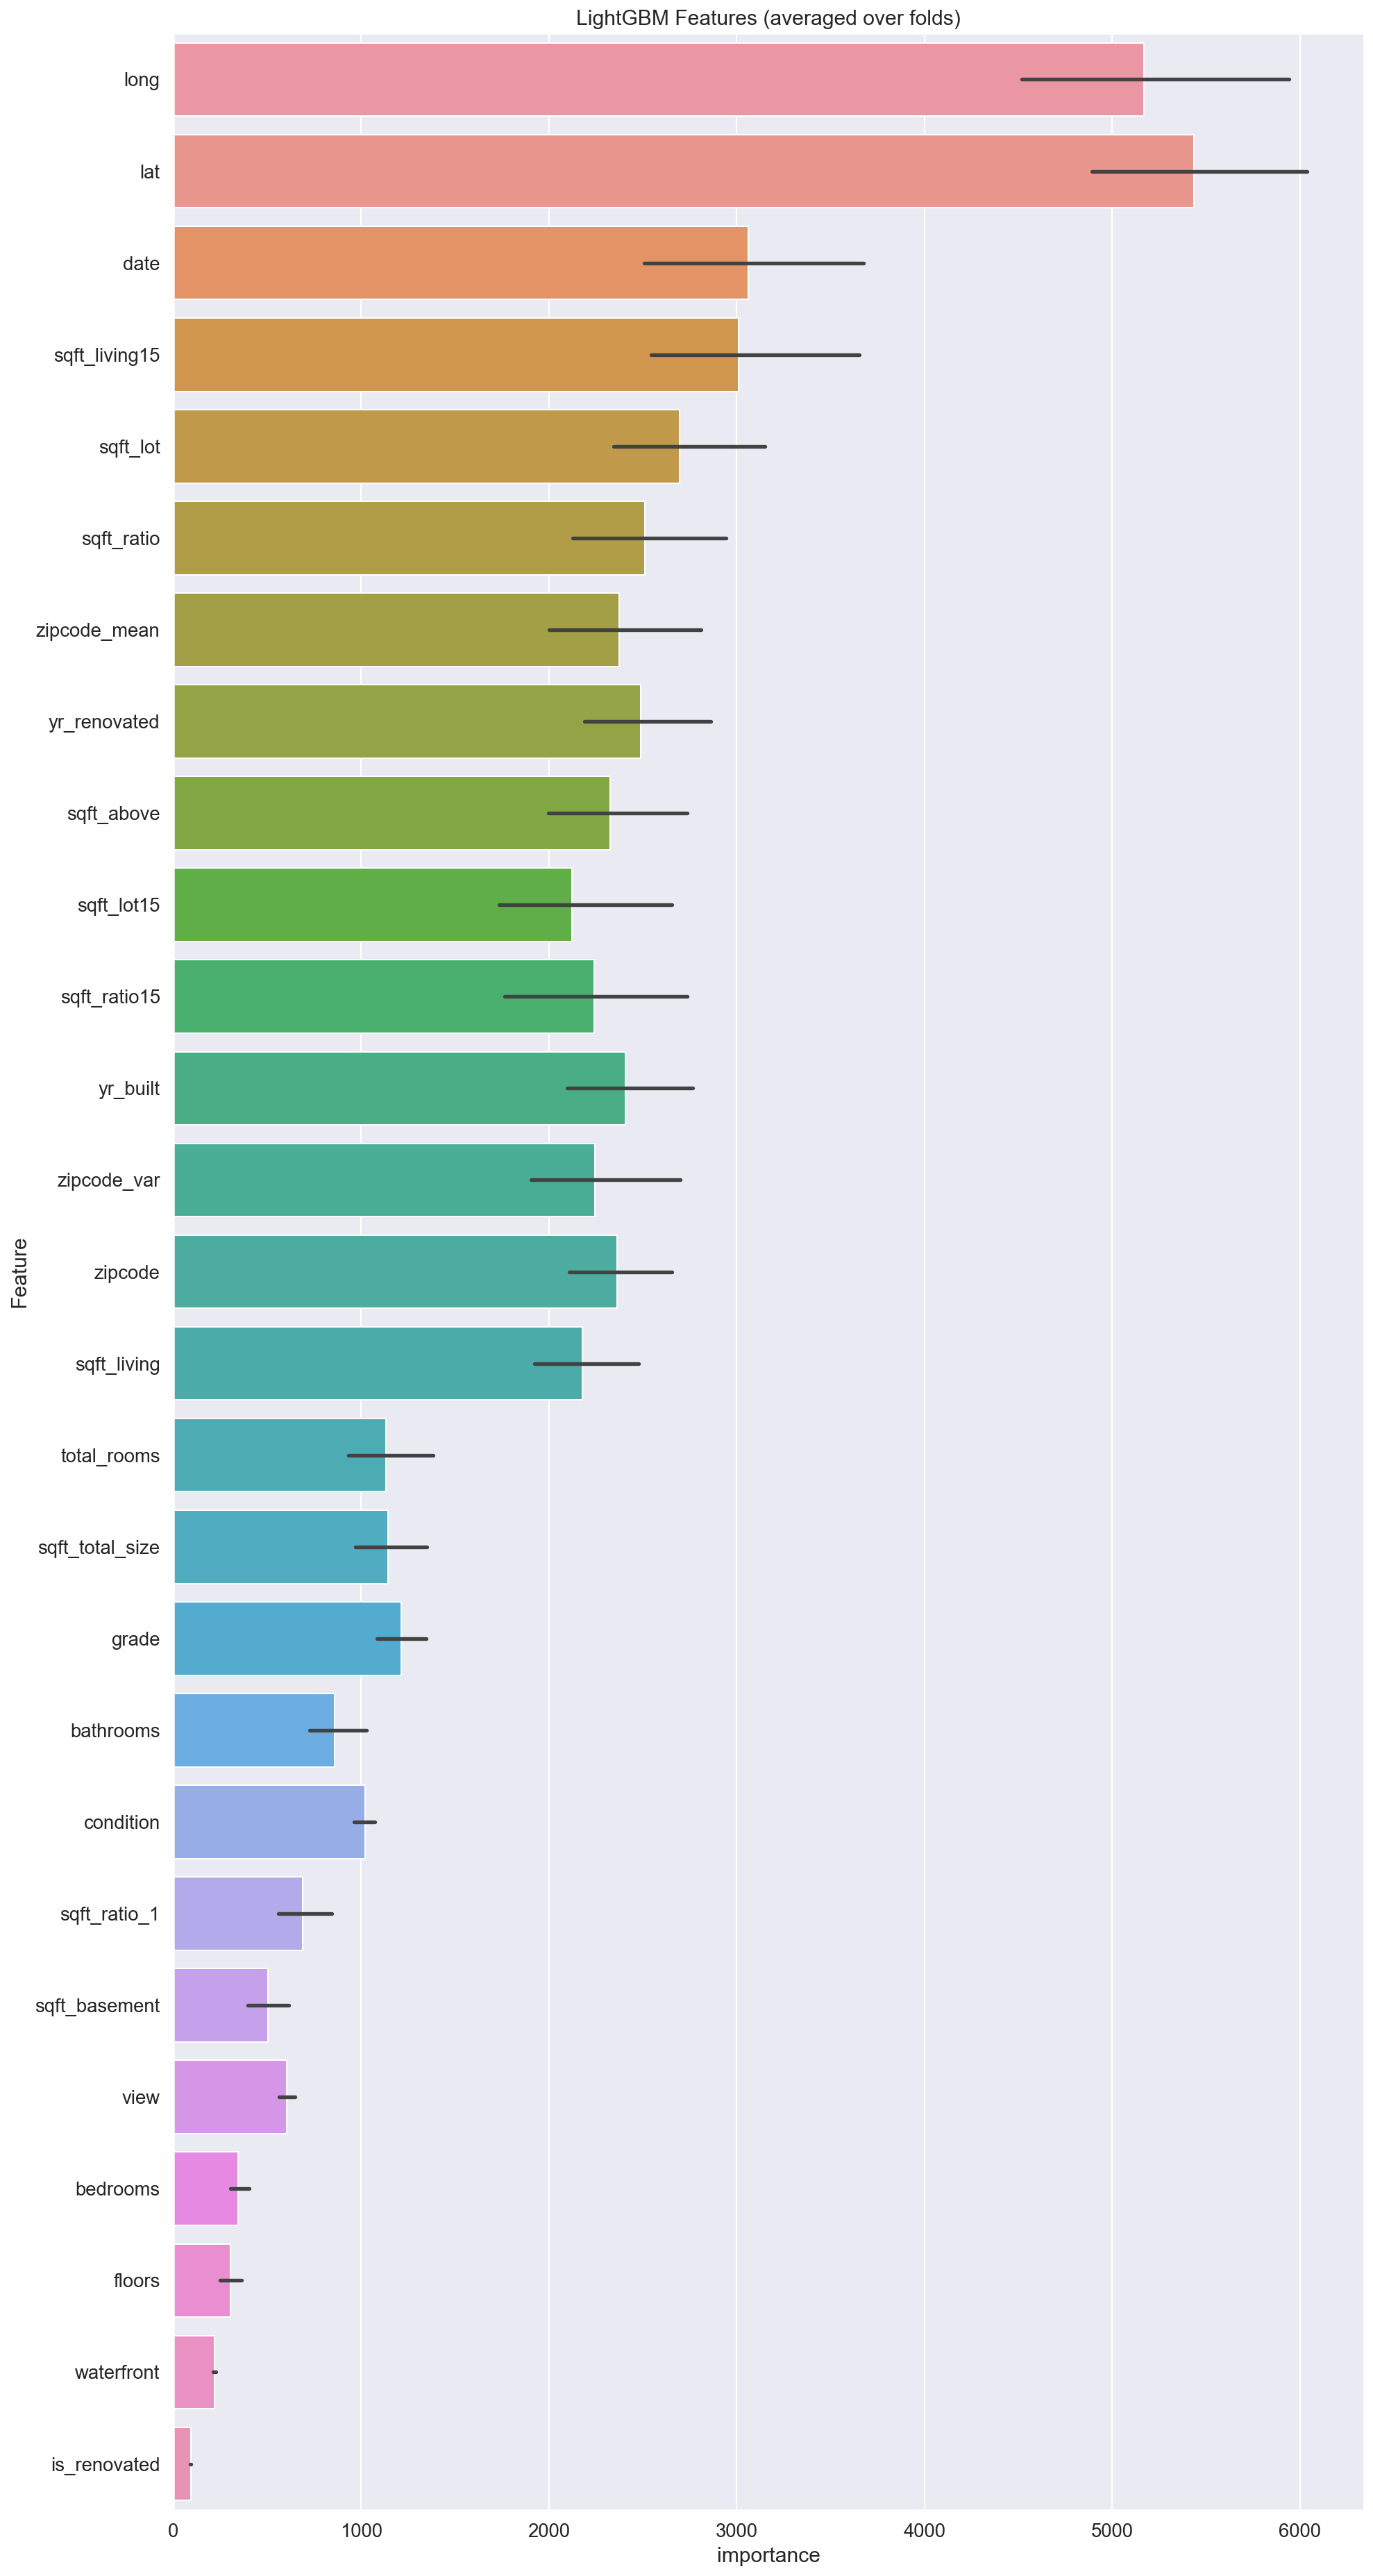

In [44]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

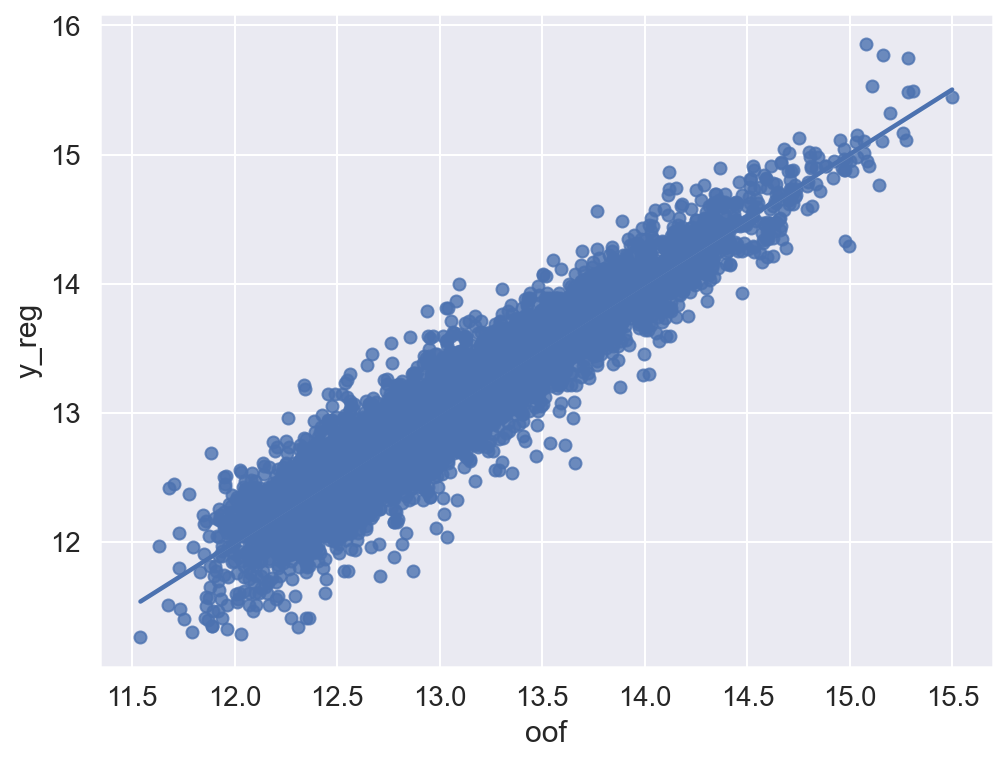

In [45]:
df_oof = pd.DataFrame(oof)
df_y_reg = pd.DataFrame(y_reg)

data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='oof', y="y_reg", data=data)

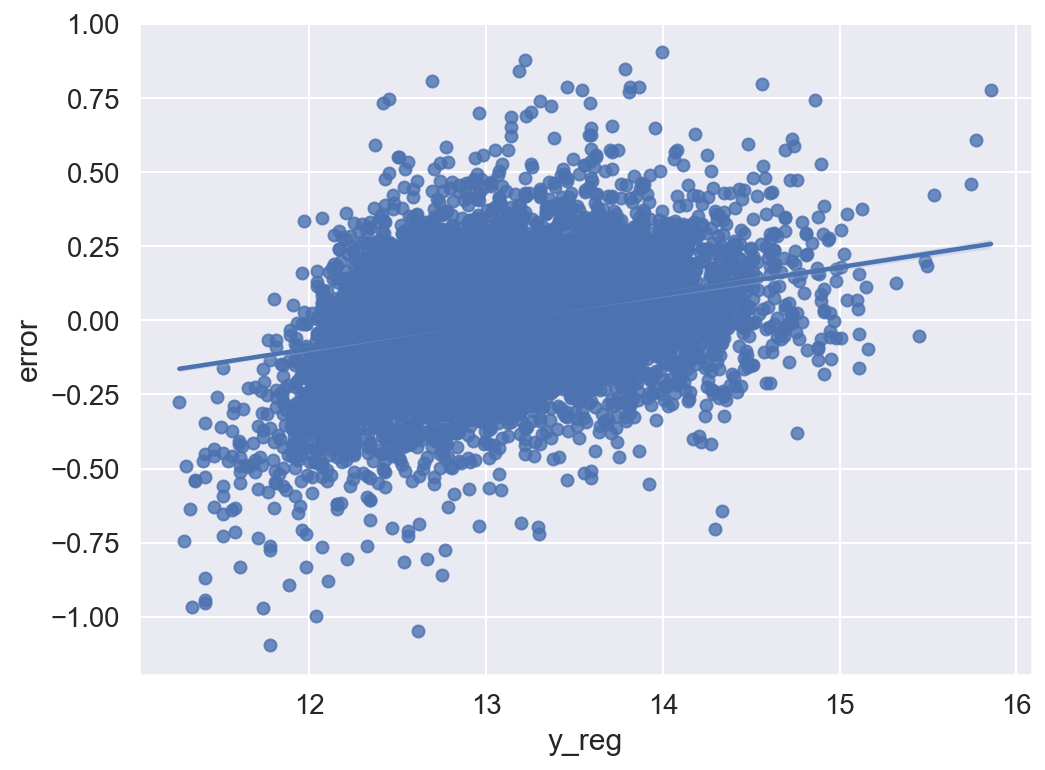

In [46]:
data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
data['error'] = data['y_reg'] - data['oof']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='y_reg', y="error", data=data)

- 실제 y_reg와 error와의 관계를 보면 잔차가 독립적이지 않는것을 볼 수 있습니다. 13~14부근은 error가 0에 가깝습니다. 하지만 15 이상은 더 높게 예측을 하는 경향을 보이고, 12이하는 더 낮게 예측하는 경향을 보입니다.

이를 개선하기 위해서는

- 15이상에서 크게 예측한 이유
- 12이하에서 작게 예측하는 이유
- error가 0.5 이상인 값들의 이유

3가지 관점에서 접근을 해야 합니다.

## 4-3. Ensemble


In [47]:
lgb1_oof = pd.DataFrame()
lgb1_oof['id'] = df_train.id
lgb1_oof['price'] = oof

lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = df_test.id
lgb1_sub['price'] = predictions

cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

117172.95952613869


In [48]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = np.expm1(df_train['price'])

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
        
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)
    

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135100	valid_1's rmse: 128002
[1000]	training's rmse: 109594	valid_1's rmse: 118267
[1500]	training's rmse: 98820.4	valid_1's rmse: 116850
Early stopping, best iteration is:
[1679]	training's rmse: 95683.6	valid_1's rmse: 116548
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 134990	valid_1's rmse: 130110
[1000]	training's rmse: 110498	valid_1's rmse: 114928
[1500]	training's rmse: 99963.8	valid_1's rmse: 111207
[2000]	training's rmse: 92091	valid_1's rmse: 109375
[2500]	training's rmse: 86103.3	valid_1's rmse: 108404
[3000]	training's rmse: 81092.5	valid_1's rmse: 107766
[3500]	training's rmse: 76831.9	valid_1's rmse: 107306


In [49]:
lgb2_oof = pd.DataFrame()
lgb2_oof['id'] = df_train.id
lgb2_oof['price'] = oof

lgb2_sub = pd.DataFrame()
lgb2_sub['id'] = df_test.id
lgb2_sub['price'] = predictions

cv2 = np.sqrt(mean_squared_error(oof, y_reg))
print(cv2)

125164.52162416193


In [50]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = df_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[19:59:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:59:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This co

In [51]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = df_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[20:02:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This co

In [52]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

117016.5961839622


In [53]:
lgb_sub = pd.merge(lgb1_sub,lgb2_sub,how='left',on='id')
lgb_sub.columns = ['id','price1','price2']
lgb_sub['price'] = (0.9*np.expm1(lgb_sub['price1']) + 0.1*lgb_sub['price2'])
lgb_sub = lgb_sub[['id','price']]

In [54]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [55]:
ensemble_sub = pd.merge(lgb_sub,xgb_sub,how='left',on='id')
ensemble_sub.columns = ['id','price1','price2']
ensemble_sub['price'] = 0.9*ensemble_sub['price1'] + 0.1*ensemble_sub['price2']
ensemble_sub = ensemble_sub[['id','price']]
ensemble_sub.to_csv("submission_ensemble_RMSLE_117016.csv",index=False)

## 회고

### 어려웠던 점

1. LMS노드를 참고하여 진행하려해도 어떻게 진행해야 할지 방향성을 잡을 수 없어 고민했다.
2. agit 와글와글에 공유해주신 링크를 참조하여 여기저기 헤메다 적합할 것으로 판단되는 커널을 찾았다.
3. 찾은 커널을 참고하여 차근차근 진행해보면서 이해가 잘 가지 않는 부분이 많았다.
    - 경험하지 못했던 library 
    - 데이터 분석을 위한 여러가지 내용(탐색적 자료분석, 통계분석 관련 지식 등)
    - 다중공선성, VIF 등 생소한 단어들(금일 LMS를 통해서 이해하게 되었다.)
4. 위의 내용들을 짧은 시간에 학습하고 이해해서 작성하는 것은 힘들다고 판단했다.
5. 첫 kaggle 도전이고 시간도 부족하니 전체적인 흐름만 파악하고 하나씩 알아가자는 마음으로 진행했다.


### 알아낸 점

- 아주 많은 것들이 있지만 떠오르는 것들

1. 통계적인 지식을 많이 쌓아야 한다는 것
2. 시각화(그래프) 표현 방법 와 pandas를 열심히 파고들어야 한다는 반성과 뉘우침
3. 데이터(숫자)가 나타내는 무언의 의미를 찾아내는 방법들
4. 또는 새로운 의미를 만들어내야 한다는 사실 등
5. 글로 표현이 안되는 무수히 많은 사항들이 있다.


#### kaggle에 제출한 점수

- 여러가지 링크를 참조하며 이리 ~ 쿵, 저리 ~ 쿵 하며 아래와 같은 결과는 나왔지만 앞으로 더 많이 노력해야함을 느끼며 마무리한다.

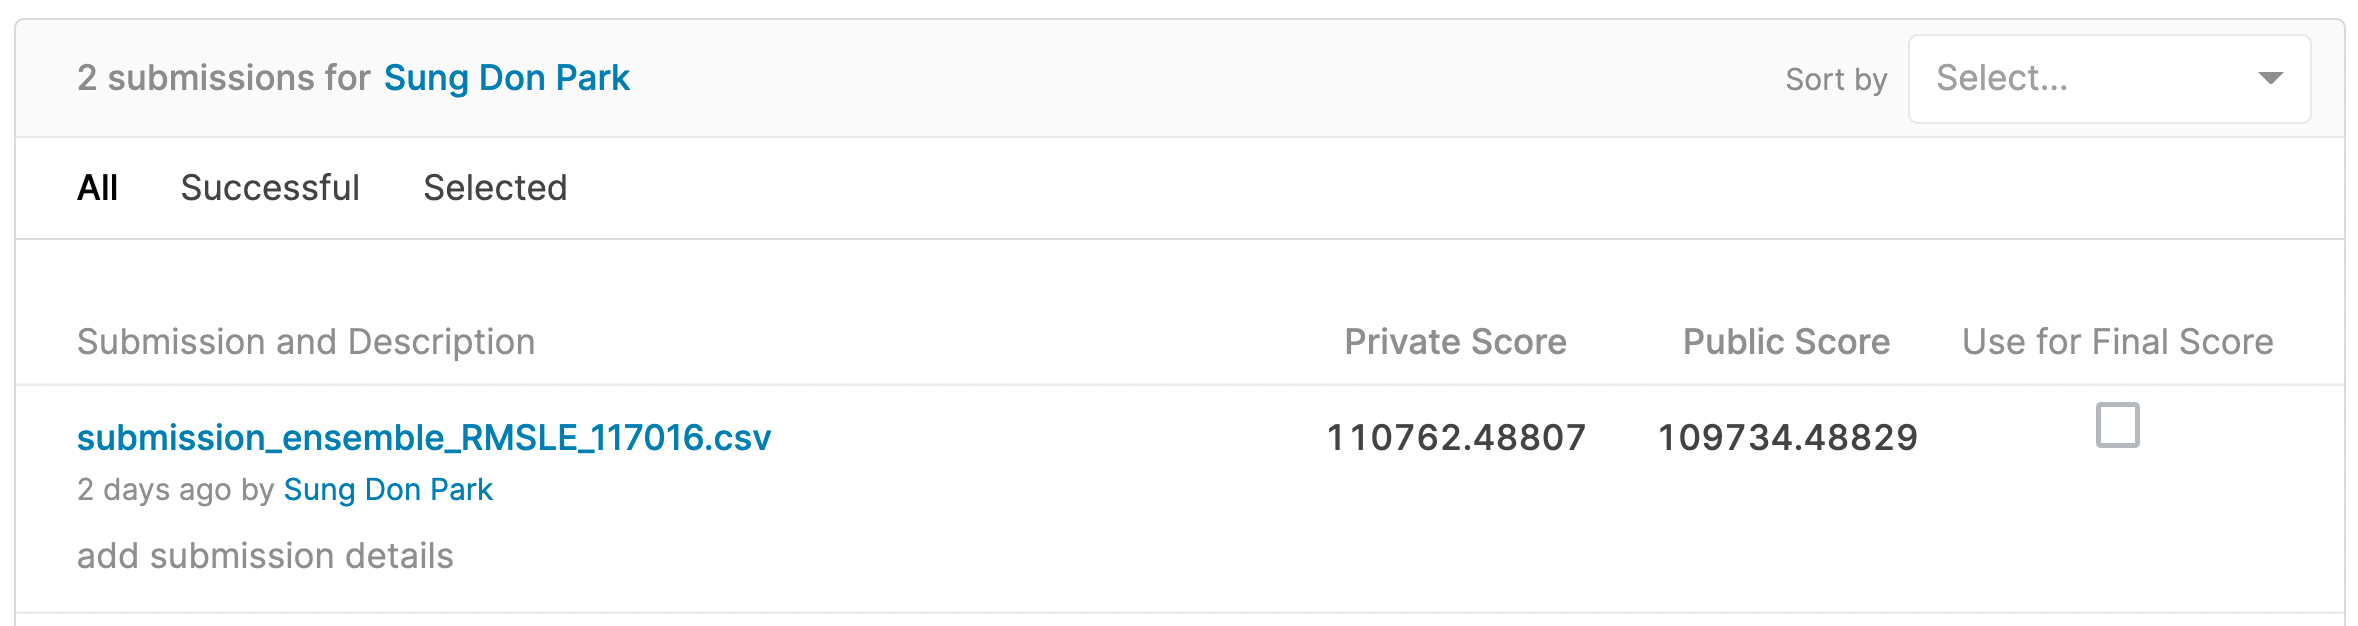